<a href="https://colab.research.google.com/github/jumpe1/learn/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[-0.20326761  0.51059539 -0.081612   ...  4.88229755  5.15585889
  3.69871148]


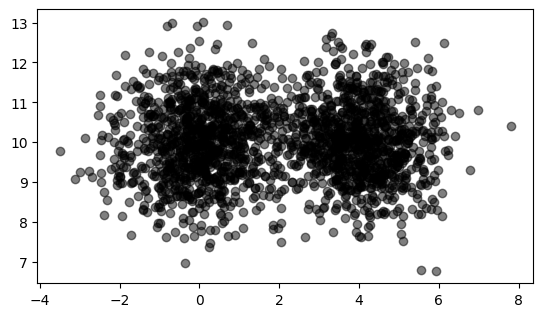

In [ ]:
# サンプルデータ作成
import numpy as np

# seed値固定
np.random.seed(874)
# x座標
x = np.r_[np.random.normal(size=1000,loc=0,scale=1),
          np.random.normal(size=1000,loc=4,scale=1)]
# y座標
y = np.r_[np.random.normal(size=1000,loc=10,scale=1),
          np.random.normal(size=1000,loc=10,scale=1)]
data = np.c_[x, y]

# 可視化処理
import matplotlib.pyplot as plt
# matplotlib inline

p = plt.subplot()
p.scatter(data[:,0], data[:,1], c = "black", alpha = 0.5)
p.set_aspect('equal')
plt.show()


In [ ]:
# クラスタ数
n_clusters = 2
# 最大ループ数
max_iter = 300
# 所属クラスタ
clusters = np.random.randint(0, n_clusters, data.shape[0])


In [ ]:
for _ in range(max_iter):
    # 中心点の更新
    # 各クラスタのデータ点の平均をとる
    centroids = np.array([data[clusters == n, :].mean(axis = 0) for n in range(n_clusters)])

    # 所属クラスタの更新
    # 一番近い中心点のクラスタを所属クラスタに更新する
    # np.linalg.normでノルムが計算できる
    # argminで最小値のインデックスを取得できる
    new_clusters = np.array([np.linalg.norm(data - c, axis = 1) for c in centroids]).argmin(axis = 0)

    # 空のクラスタがあった場合は中心点をランダムな点に割り当てなおす
    for n in range(n_clusters):
        if not np.any(new_clusters == n):
            centroids[n] = data[np.random.choice(data.shape[0], 1), :]

    # 収束判定
    if np.allclose(clusters, new_clusters):
        break

    clusters = new_clusters


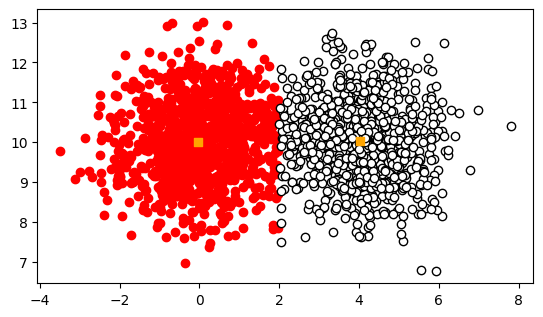

In [ ]:
p = plt.subplot()

p.scatter(data[clusters==0, 0], data[clusters==0, 1], c = 'red')
p.scatter(data[clusters==1, 0], data[clusters==1, 1], c = 'white', edgecolors='black')
# 中心点
p.scatter(centroids[:, 0], centroids[:, 1], color='orange', marker='s')

p.set_aspect('equal')

plt.show()


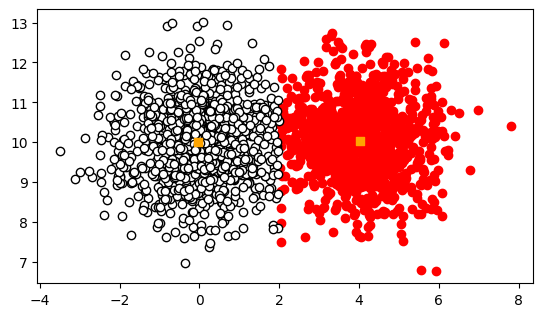

In [ ]:
from sklearn.cluster import KMeans

# k-means
km = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
clusters_sklearn = km.fit_predict(data)

# 可視化処理
p = plt.subplot()
p.scatter(data[clusters_sklearn==0, 0], data[clusters_sklearn==0, 1], c = 'red')
p.scatter(data[clusters_sklearn==1, 0], data[clusters_sklearn==1, 1], c = 'white', edgecolors='black')
p.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[: ,1], color='orange', marker='s')
p.set_aspect('equal')
plt.show()


In [ ]:
!pip install googlemaps folium

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import folium

# ダミーデータ：東京の中心部にある星4以上のレストランの緯度経度
restaurants = [
    ["Restaurant A", 35.6895, 139.6917],
    ["Restaurant B", 35.6890, 139.6907],
    ["Restaurant C", 35.6875, 139.6923],
    ["Restaurant D", 35.6844, 139.6919],
    ["Restaurant E", 35.6850, 139.7005],
    ["Restaurant F", 35.6950, 139.7035],
    ["Restaurant G", 35.6990, 139.7055],
    ["Restaurant H", 35.7000, 139.7065],
    ["Restaurant I", 35.6880, 139.7110],
    ["Restaurant J", 35.6855, 139.7120]
]

# K-meansクラスタリング
data = np.array([(lat, lng) for _, lat, lng in restaurants])
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
labels = kmeans.labels_

# 地図上にクラスタリング結果をプロット
map_center = np.mean(data, axis=0)
map = folium.Map(location=map_center.tolist(), zoom_start=14)

colors = ['red', 'blue', 'green']
for (name, lat, lng), label in zip(restaurants, labels):
    folium.Marker(
        location=[lat, lng],
        popup=f'{name}',
        icon=folium.Icon(color=colors[label])
    ).add_to(map)

# 地図を表示
map


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
import googlemaps
from sklearn.cluster import KMeans
from google.colab import userdata
import numpy as np
import folium
import time

# Google Maps APIキーを設定
API_KEY = userdata.get("map_key")
gmaps = googlemaps.Client(key=API_KEY)

# 特定の地域の星4以上のレストランを取得する関数
def fetch_restaurants(location, keyword="Restaurant", min_rating=4.0):
    restaurants = []
    results = gmaps.places_nearby(location=location, keyword=keyword, radius=5000, type='restaurant')
    while True:
        for place in results['results']:
            if place.get('rating', 0) >= min_rating:
                restaurants.append([place['name'], place['geometry']['location']['lat'], place['geometry']['location']['lng']])
        if 'next_page_token' in results:
            page_token = results['next_page_token']
            time.sleep(2)  # API から次のページの結果を正しく取得するために必要
            results = gmaps.places_nearby(page_token=page_token)
        else:
            break
    return restaurants

# レストランのデータを取得
location = "35.6895,139.6917"  # 東京の緯度経度
restaurants = fetch_restaurants(location)

# K-meansクラスタリング
data = np.array([[lat, lng] for _, lat, lng in restaurants])
k = 4  # クラスタの数
kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
labels = kmeans.labels_

# 地図上にクラスタリング結果をプロット
map_center = np.mean(data, axis=0)
map = folium.Map(location=map_center.tolist(), zoom_start=13)

# レストランのマーキング
for (name, lat, lng), label in zip(restaurants, labels):
    folium.Marker(
        location=[lat, lng],
        popup=f'{name}',
        icon=folium.Icon(color='blue' if label == 0 else 'green' if label == 1 else 'orange' if label == 2 else 'red' if label == 3 else 'purple')
    ).add_to(map)

# クラスタの中心点を赤いマーカーでプロット
for center in kmeans.cluster_centers_:
    folium.Marker(
        location=center.tolist(),
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(map)

# 地図をHTMLファイルとして保存
map.save('clustered_restaurants_map.html')
map


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
